In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from functools import lru_cache
from typing import Union, List, Tuple
import os
import sys
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
from t_core.bsplinefield import BSplineField

In [101]:
weights = torch.tensor([0.,1.,1.,0.]).view(1,4,1,1)
zeros = torch.zeros(4).view(1,4,1,1)
weights = torch.cat([zeros, weights, weights, zeros], dim=2)
zeros = torch.zeros(16).view(1,4,4,1)
weights = torch.cat([zeros, weights, weights, zeros], dim=3)
print(weights.shape)
bf = BSplineField(weights)
grid_locations = bf.origin[0] + torch.arange(0, bf.grid_size[0]) * bf.spacing[0]

torch.Size([1, 4, 4, 4])


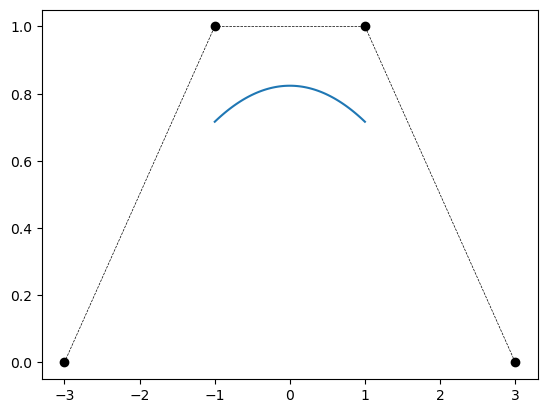

In [103]:
x = torch.linspace(-0.999,0.999,100)
y = 0.5*torch.ones_like(x)
z = 0.5*torch.ones_like(x)
u = bf.displacement(x,y,z, 0)
plt.plot(x.numpy(), u.numpy())
plt.plot(grid_locations.numpy(), bf.phi_x[0,:,1,1].numpy(), c='k', lw=0.5, ls='--', marker='o')

In [104]:
def displacement(
        self: BSplineField, 
        x: Union[torch.Tensor, np.ndarray],
        y: Union[torch.Tensor, np.ndarray],
        z: Union[torch.Tensor, np.ndarray],
        i: int, 
        **kwargs
) -> torch.Tensor:
    """Displacement at points x,y,z in the direction i.

    We implement support for locations beyond control points.

    Args:
        x (Union[torch.Tensor, np.ndarray]): x-coordinates. Can be 1d or meshgrid.
        y (Union[torch.Tensor, np.ndarray]): y-coordinates. -"-
        z (Union[torch.Tensor, np.ndarray]): z-coordinates. -"-
        i (int): index of the displacement direction. (x=0, y=1, z=2)

    Returns:
        torch.Tensor: displacement
    """
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    z = torch.Tensor(z)
    
    dx, dy, dz = self.spacing
    u = (x - self.origin[0] - dx)/dx
    v = (y - self.origin[1] - dy)/dy
    w = (z - self.origin[2] - dz)/dz
    ix = torch.floor(u).long()
    iy = torch.floor(v).long()
    iz = torch.floor(w).long()
    if not self.support_outside:
        ix_nan = (ix < 0) | (ix >= self.grid_size[0]-3)
        iy_nan = (iy < 0) | (iy >= self.grid_size[1]-3)
        iz_nan = (iz < 0) | (iz >= self.grid_size[2]-3)
    u = u - ix
    v = v - iy
    w = w - iz
    indices = []
    weights = []
    ndim, nx, ny, nz = self.phi_x.shape
    T = torch.zeros_like(x, dtype=torch.float32)
    for l in range(4):
        ix_loc = torch.clamp(ix + l, 0, self.grid_size[0]-1)
        for m in range(4):
            iy_loc = torch.clamp(iy + m, 0, self.grid_size[1]-1)
            for n in range(4):
                iz_loc = torch.clamp(iz + n, 0, self.grid_size[2]-1)
                indices.append(iz_loc + nz*(iy_loc + ny * (ix_loc + nx * i)))
                weights.append(self.bspline(u, l) * self.bspline(v, m) * self.bspline(w, n))
    indices = torch.stack(indices, dim=1)
    weights = torch.stack(weights, dim=1)
    A = torch.zeros(len(x), ndim*nx*ny*nz)
    A.scatter_(1, indices, weights)
    phi = self.phi_x.view(-1)
    T = A @ phi
    if not self.support_outside:
        T[ix_nan | iy_nan | iz_nan] = torch.nan
    return T

In [105]:
def get_A_matrix(
        self: BSplineField, 
        x: Union[torch.Tensor, np.ndarray],
        y: Union[torch.Tensor, np.ndarray],
        z: Union[torch.Tensor, np.ndarray],
        i: int, 
        **kwargs
) -> torch.Tensor:
    """Displacement at points x,y,z in the direction i.

    We implement support for locations beyond control points.

    Args:
        x (Union[torch.Tensor, np.ndarray]): x-coordinates. Can be 1d or meshgrid.
        y (Union[torch.Tensor, np.ndarray]): y-coordinates. -"-
        z (Union[torch.Tensor, np.ndarray]): z-coordinates. -"-
        i (int): index of the displacement direction. (x=0, y=1, z=2)

    Returns:
        torch.Tensor: displacement
    """
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    z = torch.Tensor(z)
    
    dx, dy, dz = self.spacing
    u = (x - self.origin[0] - dx)/dx
    v = (y - self.origin[1] - dy)/dy
    w = (z - self.origin[2] - dz)/dz
    ix = torch.floor(u).long()
    iy = torch.floor(v).long()
    iz = torch.floor(w).long()
    if not self.support_outside:
        ix_nan = (ix < 0) | (ix >= self.grid_size[0]-3)
        iy_nan = (iy < 0) | (iy >= self.grid_size[1]-3)
        iz_nan = (iz < 0) | (iz >= self.grid_size[2]-3)
    u = u - ix
    v = v - iy
    w = w - iz
    indices = []
    weights = []
    ndim, nx, ny, nz = self.phi_x.shape
    T = torch.zeros_like(x, dtype=torch.float32)
    for l in range(4):
        ix_loc = torch.clamp(ix + l, 0, self.grid_size[0]-1)
        for m in range(4):
            iy_loc = torch.clamp(iy + m, 0, self.grid_size[1]-1)
            for n in range(4):
                iz_loc = torch.clamp(iz + n, 0, self.grid_size[2]-1)
                indices.append(iz_loc + nz*(iy_loc + ny * (ix_loc + nx * i)))
                weights.append(self.bspline(u, l) * self.bspline(v, m) * self.bspline(w, n))
    indices = torch.stack(indices, dim=1)
    weights = torch.stack(weights, dim=1)
    A = torch.zeros(len(x), ndim*nx*ny*nz)
    A.scatter_(1, indices, weights)
    return A

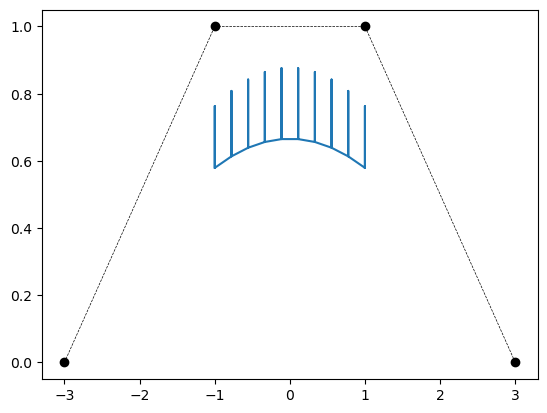

In [121]:
x = torch.linspace(-0.999,0.999,10)
y = torch.linspace(-0.999,0.999,10)
z = torch.linspace(-0.999,0.999,10)
X,Y,Z = torch.meshgrid(x,y,z, indexing='ij')
X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
u = displacement(bf, X,Y,Z, 0)
A = get_A_matrix(bf, X,Y,Z, 0)
plt.plot(X.numpy(), u.numpy())
plt.plot(grid_locations.numpy(), bf.phi_x[0,:,1,1].numpy(), c='k', lw=0.5, ls='--', marker='o')

In [122]:
u

tensor([0.5792, 0.6135, 0.6392, 0.6563, 0.6648, 0.6648, 0.6563, 0.6392, 0.6135,
        0.5792, 0.6135, 0.6497, 0.6769, 0.6951, 0.7041, 0.7041, 0.6951, 0.6769,
        0.6497, 0.6135, 0.6392, 0.6769, 0.7053, 0.7242, 0.7336, 0.7336, 0.7242,
        0.7053, 0.6769, 0.6392, 0.6563, 0.6951, 0.7242, 0.7436, 0.7533, 0.7533,
        0.7436, 0.7242, 0.6951, 0.6563, 0.6648, 0.7041, 0.7336, 0.7533, 0.7631,
        0.7631, 0.7533, 0.7336, 0.7041, 0.6648, 0.6648, 0.7041, 0.7336, 0.7533,
        0.7631, 0.7631, 0.7533, 0.7336, 0.7041, 0.6648, 0.6563, 0.6951, 0.7242,
        0.7436, 0.7533, 0.7533, 0.7436, 0.7242, 0.6951, 0.6563, 0.6392, 0.6769,
        0.7053, 0.7242, 0.7336, 0.7336, 0.7242, 0.7053, 0.6769, 0.6392, 0.6135,
        0.6497, 0.6769, 0.6951, 0.7041, 0.7041, 0.6951, 0.6769, 0.6497, 0.6135,
        0.5792, 0.6135, 0.6392, 0.6563, 0.6648, 0.6648, 0.6563, 0.6392, 0.6135,
        0.5792, 0.6135, 0.6497, 0.6769, 0.6951, 0.7041, 0.7041, 0.6951, 0.6769,
        0.6497, 0.6135, 0.6497, 0.6882, 

In [123]:
A

tensor([[4.6088e-03, 1.8463e-02, 4.6227e-03,  ..., 2.8923e-22, 7.2415e-23,
         9.0363e-33],
        [3.2375e-03, 1.8138e-02, 6.3127e-03,  ..., 2.8413e-22, 9.8889e-23,
         1.0023e-25],
        [2.1694e-03, 1.7245e-02, 8.2298e-03,  ..., 2.7014e-22, 1.2892e-22,
         7.9647e-25],
        ...,
        [7.9647e-25, 1.2892e-22, 2.7014e-22,  ..., 8.2298e-03, 1.7245e-02,
         2.1694e-03],
        [1.0023e-25, 9.8889e-23, 2.8413e-22,  ..., 6.3127e-03, 1.8138e-02,
         3.2375e-03],
        [9.0363e-33, 7.2415e-23, 2.8923e-22,  ..., 4.6227e-03, 1.8463e-02,
         4.6088e-03]])

In [124]:
torch.linalg.lstsq(A, u.unsqueeze(1)).solution.view(-1)

tensor([ 4.9899e-04,  9.0312e-04,  9.5332e-04,  5.4526e-04, -1.1676e-04,
         7.8044e-02,  7.8031e-02, -1.2506e-04,  8.1060e-05,  7.8634e-02,
         7.8643e-02,  7.4659e-05, -1.2512e-04, -1.1611e-03, -1.1852e-03,
        -7.4230e-05,  1.9937e-03,  1.1203e-03,  1.3466e-03,  2.0853e-03,
        -5.4374e-04,  9.8482e-01,  9.8475e-01, -5.5048e-04,  4.8667e-04,
         9.8556e-01,  9.8562e-01,  4.6295e-04, -1.4205e-03, -1.5060e-03,
        -1.6927e-03, -1.2810e-03, -6.5121e-05, -3.8608e-03, -3.8288e-03,
        -2.1154e-04, -1.0064e-04,  1.0023e+00,  1.0023e+00, -6.0263e-05,
         2.3455e-04,  9.9979e-01,  9.9982e-01,  2.3798e-04, -1.3688e-03,
         4.8648e-03,  4.7326e-03, -1.4714e-03, -1.0993e-04, -5.8082e-04,
        -5.8796e-04, -1.3445e-04,  1.3926e-05,  8.6101e-02,  8.6102e-02,
         1.9742e-05,  7.1552e-06,  8.5724e-02,  8.5725e-02,  8.8101e-06,
        -1.1375e-04,  7.3667e-04,  7.2819e-04, -1.3475e-04])

In [125]:
sol = torch.linalg.lstsq(A, u.unsqueeze(1)).solution.view(-1)

In [126]:
bf.phi_x.view(-1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

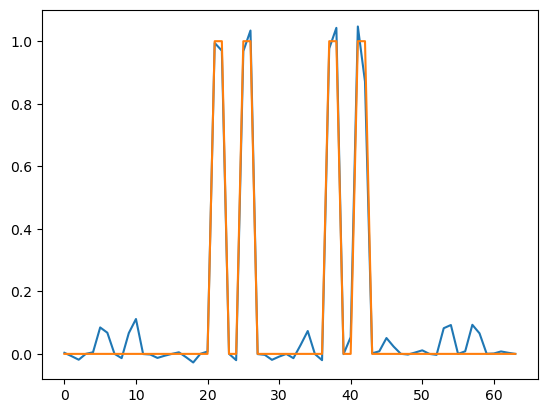

In [127]:
plt.plot(sol.numpy())
plt.plot(bf.phi_x.view(-1).numpy())